# Libraries

In [51]:
import pickle
import pandas as pd
import seaborn as sns
from os.path import exists
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix



import nltk.metrics
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Ilay2\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


# Loading the Files

Download the csv files into the `data/` directory.

train.csv shape is  (50000, 9)
test.csv shape is  (212192, 2)

        Id   ProductId          UserId  HelpfulnessNumerator  \
0   914403  B0009W5KHM   AV6QDP8Q0ONK4                     2   
1   354887  6303079709  A2I8RXJN80A2D2                     0   
2  1407653  B004H0M2XC  A3FHV3RV8Z12E6                     0   
3  1377458  B003ZJ9536  A12VLTA3ZHVPUY                     1   
4   475323  630574453X  A13NM1PES9OXVN                     2   

   HelpfulnessDenominator        Time  \
0                       2  1341014400   
1                       0  1168819200   
2                       0  1386201600   
3                       1  1348704000   
4                       3   970012800   

                                         Summary  \
0                                  GOOD FUN FILM   
1                                   Movie Review   
2             When is it a good time to Consent?   
3                                          TRUTH   
4  Intelligent and bittersweet -- stays with 

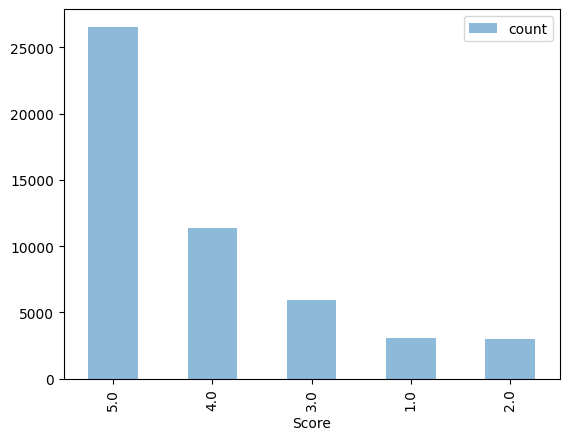


EVERYTHING IS PROPERLY SET UP! YOU ARE READY TO START


In [52]:
trainingSet = pd.read_csv("./data/train.csv",  nrows=50000)
testingSet = pd.read_csv("./data/test.csv")

print("train.csv shape is ", trainingSet.shape)
print("test.csv shape is ", testingSet.shape)

print()

print(trainingSet.head())
print()
print(testingSet.head())

print()

print(trainingSet.describe())
trainingSet['Score'].value_counts().plot(kind='bar', legend=True, alpha=.5)
plt.show()

print()
print("EVERYTHING IS PROPERLY SET UP! YOU ARE READY TO START")

A lot of reviews with 5 stars. And then far fewer with 4, 3, 1, & 2. 
We could try to train a model with even distribution of reviews!

# Adding Features

Attempts to find interesting features:
Urgent language: capitals and exclamation marks
Review Length: average length of 1 to 5 star reviews

Conclusion: Not useful. Urgent spelling is barely more appearent in 5 star reviews (and there are disproportionately more 5 star reviews), so nothing can be said about that. Review length seems arbitrary; bar chart almost looks like normal distribution.
As such these extractors were given their own section.

In [8]:
def extract_urgnecy(df):
    df['Capitals_Summary'] = df['Summary'].str.count(r'[A-Z]')
    df['Exclamations_Summary'] = df['Summary'].str.count('!')
    df['Capitals_Text'] = df['Text'].str.count(r'[A-Z]')
    df['Exclamations_Text'] = df['Text'].str.count('!')

    #Total number of capitals and exclamations
    df['Capitals'] = df['Capitals_Summary'] + df['Capitals_Text']
    df['Exclamations'] = df['Exclamations_Summary'] + df['Exclamations_Text']

    #Length of Summary and Text combined
    df['Total_Length'] = df['Summary'].str.len() + df['Text'].str.len()

    #Urgency score
    df['Urgency_Score'] = (df['Capitals'] + df['Exclamations']) / df['Total_Length']

    #Fill any NaN values with 0 (in case of empty summaries/texts)
    df['Urgency_Score'] = df['Urgency_Score'].fillna(0)

    #Drop intermediate columns used for calculation
    df.drop(columns=['Capitals_Summary', 'Exclamations_Summary', 'Capitals_Text', 'Exclamations_Text', 'Capitals', 'Exclamations', 'Total_Length'], inplace=True)

    return df

In [23]:
def urgency_to_score_visualization(trainingSet):
  avg_urgencyScore = trainingSet.groupby('Score')['Urgency_Score'].mean()

  plt.bar(avg_urgencyScore.index, avg_urgencyScore.values)
  #plt.xlabel('Rating')
  #plt.ylabel('Urgency Score')
  plt.show()

In [24]:
def review_length_visualization(trainingSet):
  avg_revLength = trainingSet.groupby('Score')['Review_Length'].mean()
  print(avg_revLength.index, avg_revLength.values)
  plt.bar(avg_revLength.index, avg_revLength.values)
  #plt.xlabel('Rating')
  #plt.ylabel('Review Length')
  plt.show()

In [25]:
def calculate_sentiment(text):
    #Returns a dictionary with pos, neu, neg, and compound scores
    if isinstance(text, str):  # Process only if the text is a string
        sentiment = sia.polarity_scores(text)
        return sentiment['compound']
    else:
        return 0

In [53]:
#suggestion: TAKE 10000 ROWS FROM TRAIN.CSV AND WORK WITH IT FOR ENTIRETY OF COMP
def add_features_to(df):
    # This is where you can do all your feature extraction
    #Whatever you can think of. Is there a relationship between this feature and the score.
        #Ex: Number of exclamation marks and the score
        #Could build youur own language processing model, the presence of these words, punctuation, emoji, etc
        #Number of words for the amount of review. Like maybe a 1 star review has less words
        #PLOT LOTS OF THINGFS & ATTRRIBUTES. modeling COMES LAST
        
    df['Helpfulness'] = df['HelpfulnessNumerator'] / df['HelpfulnessDenominator']
    df['Helpfulness'] = df['Helpfulness'].fillna(0)
    
    df['Review_Length'] = df['Text'].str.len()
    df['Review_Length'] = df['Review_Length'].fillna(0)

    #Language learning of positive/negative language
    df['Sentiment_Score'] = df['Text'].apply(calculate_sentiment)
    df['Summary_Sentiment_Score'] = df['Summary'].apply(calculate_sentiment)
    return df

# Load the feature extracted files if they've already been generated
if exists('./data/X_train.csv'):
    X_train = pd.read_csv("./data/X_train.csv")
if exists('./data/X_submission.csv'):
    X_submission = pd.read_csv("./data/X_submission.csv")

else:
    # Process the DataFrame
    train = add_features_to(trainingSet)
    print(train.groupby('Score')['Sentiment_Score'].mean())
    print(train.groupby('Score')['Summary_Sentiment_Score'].mean())
    print(train.groupby('Score')['Review_Length'].mean())
    print(train.groupby('Score')['Helpfulness'].mean())

    #urgency_to_score_visualization(train)
    #review_length_visualization(train)

    # Merge on Id so that the submission set can have feature columns as well
    X_submission = pd.merge(train, testingSet, left_on='Id', right_on='Id')
    X_submission = X_submission.drop(columns=['Score_x'])
    X_submission = X_submission.rename(columns={'Score_y': 'Score'})

    # The training set is where the score is not null
    X_train =  train[train['Score'].notnull()]

    X_submission.to_csv("./data/X_submission.csv", index=False)
    X_train.to_csv("./data/X_train.csv", index=False)

Score
1.0   -0.118267
2.0    0.140217
3.0    0.432909
4.0    0.604366
5.0    0.700823
Name: Sentiment_Score, dtype: float64
Score
1.0   -0.152614
2.0   -0.061677
3.0    0.095753
4.0    0.223993
5.0    0.295257
Name: Summary_Sentiment_Score, dtype: float64
Score
1.0     845.212787
2.0    1126.078255
3.0    1109.195543
4.0    1114.569747
5.0     779.005198
Name: Review_Length, dtype: float64
Score
1.0    0.359194
2.0    0.366540
3.0    0.372612
4.0    0.435763
5.0    0.399610
Name: Helpfulness, dtype: float64


# Sample + Split into training and testing set

In [54]:
# Split training set into training and testing set
X_train, X_test, Y_train, Y_test = train_test_split(
    X_train.drop(columns=['Score']),
    X_train['Score'],
    test_size=1/4.0,
    random_state=0
)

# Feature Selection

In [55]:
'''
After new features are created by add_features_to or other functions, 
the list of features specifies which subset of features will be used for model training. 
'''
features = ['Sentiment_Score', 'Summary_Sentiment_Score', 'HelpfulnessNumerator','HelpfulnessDenominator',  ]


#We created all these features, but which ones do we wanna use in our models. 
#For example, the ones selected here are all numerical, so it helps to use for KNN
X_train_select = X_train[features]
X_test_select = X_test[features]
X_submission_select = X_submission[features]

# Model Creation

In [56]:
# Learn the model
#model = KNeighborsClassifier(n_neighbors=3).fit(X_train_select, Y_train)

#Try learning Model with Random forest
model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=0)
model.fit(X_train_select, Y_train)

# Predict the score using the model
Y_test_predictions = model.predict(X_test_select)

# Model Evaluation

Accuracy on testing set =  0.5544


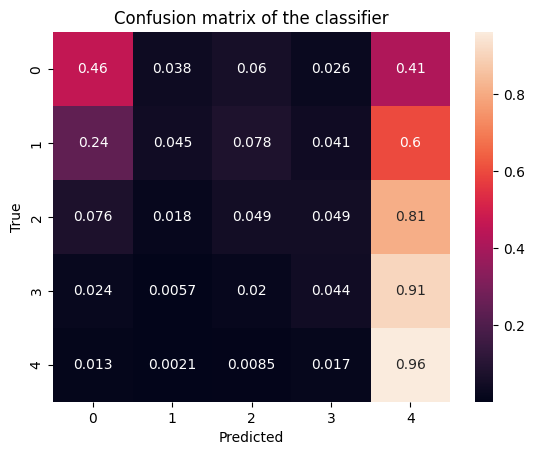

In [57]:
# Evaluate your model on the testing set
print("Accuracy on testing set = ", accuracy_score(Y_test, Y_test_predictions))

# Plot a confusion matrix
cm = confusion_matrix(Y_test, Y_test_predictions, normalize='true')
sns.heatmap(cm, annot=True)
plt.title('Confusion matrix of the classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Create submission file

In [12]:
# Create the submission file
#Make submission files sparingly. Only 5 per day
#Add link to github repo commit id in the description of the submission
X_submission['Score'] = model.predict(X_submission_select)
submission = X_submission[['Id', 'Score']]
submission.to_csv("./data/submission.csv", index=False)